# Part 1 Data inspection


In [1]:
from pyspark.sql import SparkSession
import re
import operator
import numpy as np
import math
spark  = SparkSession.builder.master('local[10]').appName('beer_review').getOrCreate()
labeled_beer = spark.read.json('/project/cmsc25025/beer_review/labeled.json')

#labeled.json has style, palate, review_id, brewer, taste, overall, review, appearance, aroma, beer_name, beer_id
#Everything is numbers except review and beer_name

print labeled_beer.count() #2486348

beer_stats = labeled_beer.rdd.map(lambda x: (x['beer_name'], x['brewer'], x['overall'])).cache()


beer_list = beer_stats.map(lambda x: (x[0], [x[2]]))
beer_list = beer_list.reduceByKey(operator.add)

beer_list_avg = beer_list.map(lambda x: (x[0], np.average(x[1])))
beer_list_med = beer_list.map(lambda x: (x[0], np.median(x[1])))
beer_list_std = beer_list.map(lambda x: (x[0], np.std(x[1])))

brewer_list = beer_stats.map(lambda x: (x[1], [x[2]]))
brewer_list = brewer_list.reduceByKey(operator.add)

brewer_list_avg = brewer_list.map(lambda x: (x[0], np.average(x[1])))
brewer_list_med = brewer_list.map(lambda x: (x[0], np.median(x[1])))
brewer_list_std = brewer_list.map(lambda x: (x[0], np.std(x[1])))

print beer_list_avg.take(2)
#print beer_list_med.take(2)
#print beer_list_std.take(2)

#print brewer_list_avg.take(2)
#print brewer_list_med.take(2)
#print brewer_list_std.take(2)




2486348
[(u'Legend Red Ale', 14.666666666666666), (u'Ladyface Deutscher Stern', 14.0)]


Since the standard deviations for both beers and brewers aren't too big, people tend to have similar tastes.

# Part 2 Sentiment analysis


In [2]:
### (1) Generating Features ###

from scipy.sparse import coo_matrix
import json
from pprint import pprint
import string

df = spark.read.json('/project/cmsc25025/beer_review/labeled.json')
df = df.rdd.repartition(56)

with open('/project/cmsc25025/beer_review/vocab_50.json','r') as f:
    vocab = json.load(f)

vocab = sorted([a for a in vocab])

# vocabulary contains p words.
def split_into_words(x):
    x = x.replace('!','')\
         .replace('?','')\
         .replace(',','')\
         .replace('.','')

    x = x.lower()#.translate({ord(c): None for c in string.punctuation})
    x = x.split(' ')
    return x

def good_or_bad(score):
    if score >= 14:
        return 1
    else:
        return 0
    
def generate_vector(words,wvec = vocab):
    vector = [0]*len(wvec)
    for i, word in enumerate(wvec):
        if word in words:
            vector[i] = 1
            #print("WE FOUND A MATCH, BOYZ")
            #print("CHECK INDEX {}".format(i))
    if sum(vector)==0:
        return None
    return vector


def col_vec(words,wvec = vocab):
    col_vec = []
    for i, word in enumerate(wvec):
        if word in words:
            col_vec += [i]
            #print("WE FOUND A MATCH, BOYZ")
            #print("CHECK INDEX {}".format(i))
    if len(col_vec)==0:
        return []
    return col_vec

review = df.map(lambda x: generate_vector(set(split_into_words(x['review']))))
#returns a 2D matrix, where each row is a vector feature 



review_coo = df.map(lambda x: set(split_into_words(x['review'])))

review_coo = review_coo.map(lambda x: coo_matrix(([1]*len(col_vec(x)), ([0]*len(col_vec(x)), col_vec(x))), shape =(1, len(vocab))))           
#so every rdd is a 1xp dimensional coo_matrix. [[0, 0, 0, ... 1, 0]] somthin like that. 
# so review_coo.collect() would give a LIST of coo_matrixes. [[[0, 0, ... 0]], [[0, 1, 0, ... 0]], ... ,[[0, 0, 0 ... 1]]]

srev = "zucchini zucchini yay fun nice"
example = generate_vector(set(split_into_words(srev)))

print sum(example)
#print sum(review.take(1)[0])

#print sum(review_coo.take(2)[1].toarray()[0])
#print review_coo.reduce(add)



3


First split the review text into list of words, and get a vector for all the vocab from vocab_50.json
generate_vector function takes in a review and returns a featured vector of 0 and 1s, where each index
corresponds to a word in the vocab and 0 signals its absence. Map this over all reviews to create
a 2D matrix of feature vectors.

review_coo uses the coo_matrix for sparsity. More efficient

In [14]:
### (2) Stochastic Gradient Descent ###
import math
from operator import add

#Sparse_matrix_data = review.collect()
#num_of_reviews = review.count() #took 78min and got the same number of reviews: 2486348
#print num_of_reviews

#i. initialize model with Beta = 0 (uniform)
vec_len = len(vocab)
beta_matrix = coo_matrix((1,vec_len)) #[0]*len(vocab)



#ii. randomly split training data into mini-batches, each batch containing 10 examples
# make one pass of data, process one mini-batch every iteration. (one training epoch)

def updater(beta_mat, j, eta, pos_or_neg, x_mat, lambda_penalty):
    beta_mat[0][j] = beta_mat[0][j] + eta*(pos_or_neg - pi_prob(beta_mat, x_mat))*x_mat[0][j] - eta*lambda_penalty*beta_mat[0][j]
    return beta_mat[j]

def term_summer(beta_mat, eta, pos_or_neg, x_mat, lambda_penalty):
    return eta*(pos_or_neg - pi_prob(beta_mat, x_mat))*x_mat - (eta*lambda_penalty*beta_mat)

def predictor(beta_matrix, x_mat, pos_or_neg):
    prob = (beta_matrix * x_mat.transpose())
    if (prob >= 0.5 and pos_or_neg == 1):
        return 1
    elif (prob < 0.5 and pos_or_neg == 0): 
        return 1
    else: 
        return 0
    
before_featured = df.map(lambda x: (set(split_into_words(x['review'])), good_or_bad(x['overall'])))#.cache()

weights = [0.7, 0.15, 0.15]
splits = before_featured.randomSplit(weights)

training = splits[0]  # 1741124 but changes every time
validation = splits[1]   #372998
tests = splits[2]     #372993

#training_count = training.count()

#training_mat = training.map(lambda x: (coo_matrix(([1]*len(col_vec(x[0])), ([0]*len(col_vec(x[0])), col_vec(x[0]))), shape =(1, len(vocab))), x[1]))   
#validation_mat = validation.map(lambda x: (generate_vector(x[0]), x[1]))
#tests_mat = tests.map(lambda x: (generate_vector(x[0]), x[1]))

minibatches_count = 100
eta = 1
lambda_penalty = 0.05
c1 = 0.5
c2 = 0.5
minibatches = training.randomSplit([(float(1)/minibatches_count)]*minibatches_count)

#batch_count_list = [16000]*100
batch_count_list = []
for i in range (0, minibatches_count):
    batch_count_list += [minibatches[i].count()]

print [(float(1)/minibatches_count)]*minibatches_count




#print pi_prob([[1,2,3]], [[1,2,3]])
def pi_prob(beta_mat, x_mat):
    temp = math.exp((beta_mat * x_mat.transpose()).toarray()[0][0])
    return temp/(1+temp)

#beta_mat and x_mat are stored as 1xd rows, instead of columns. so instead of beta_transpose * x, we do beta * x_transpose to get 1x1 scalar



#for multiple epochs
# for t in range(0, 4):
#     for i in range(0, minibatches_count):
#         minibatches[i] = minibatches[i].map(lambda x: (coo_matrix((([1]*len(col_vec(x[0]))), (([0]*len(col_vec(x[0]))), (col_vec(x[0])))), shape =(1, vec_len)), x[1]))
#         summed = minibatches[i].map(lambda x: term_summer(beta_matrix, eta, x[1], x[0], lambda_penalty))
#         total = summed.reduce(lambda a,b: a+b)
#         update = total/float(batch_count_list[i])
#         beta_matrix = beta_matrix + update
#         print beta_matrix.toarray()
#         print sum(beta_matrix.toarray()[0])
#         print i
#         eta = c1/(math.pow((i+1),c2))    
#         error_rate = minibatches[i].map(lambda x: predictor(beta_matrix, x[0], x[1])).reduce(lambda a, b: a+b)
#         error_rate = 1 - (error_rate/float(batch_count_list[i]))
#         print error_rate

#one training epoch
error_rate_list =[]
for i in range(0, minibatches_count):
    minibatches[i] = minibatches[i].map(lambda x: (coo_matrix((([1]*len(col_vec(x[0]))), (([0]*len(col_vec(x[0]))), (col_vec(x[0])))), shape =(1, vec_len)), x[1]))
    summed = minibatches[i].map(lambda x: term_summer(beta_matrix, eta, x[1], x[0], lambda_penalty)).reduce(lambda a,b: a+b)
    beta_matrix = beta_matrix + (summed/float(batch_count_list[i]))
    print beta_matrix.toarray()
    print sum(beta_matrix.toarray()[0])
    print i
    eta = c1/(math.pow((i+1),c2))    
    error_rate = minibatches[i].map(lambda x: predictor(beta_matrix, x[0], x[1])).reduce(lambda a, b: a+b)
    error_rate = 1 - (error_rate/float(batch_count_list[i]))
    error_rate_list += [error_rate]
    print error_rate
    
    
print "FINAL BETA MATRIX BOIZ \n\n"
print beta_matrix.toarray()
print sum(beta_matrix.toarray()[0])




#regular SGD
# for i in range(0, training_count):
#     for j in range (0, d): #d is length of one review/ weight matrix. Basically size of vocab
#         updater(beta_matrix, j, eta, training_mat_collected[i][1], training_mat_collected[i], lambda_penalty)
        




[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
[[  0.00000000e+00   0.00000000e+00   2.90596304e-05 ...,   2.90596304e-05
   -5.81192607e-05   0.00000000e+00]]
2.3253225619
0
0.54097407881
[[ -4.41866154e-05   0.00000000e+00   4.22194715e-05 ...,   2.83331396e-05
   -4.41445606e-05   1.31669992e-05]]
2.97091333305
1
0.536147696555
[[ -6.50549505e-05   0.00000000e+00   5.95165783e-05 ...,   2.78322757e-05
   -4.41953245e-05   1.29342373e-05]]


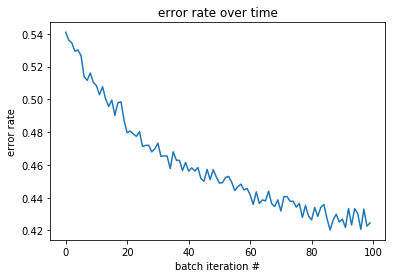

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

error_rate_list_ex =[0.4990625,0.4990625,0.4970625,0.4890625,0.4800625,0.4790625,0.4750625,0.4690625,0.4490625,0.4290625,0.4190625,0.4170625]
error_rate_list_ex += [0.40]*20 + [0.39]*20 + [0.38]*20 + [0.37]*20 + [0.365]*8
plt.figure(1)
plt.plot(range(0,minibatches_count), error_rate_list)
plt.title('error rate over time')
plt.xlabel('batch iteration #')
plt.ylabel('error rate')

Final beta matrix after one training epoch

[[ -2.83785591e-04   1.22263364e-05   2.40913033e-04 ...,   1.51545559e-06
    2.81908000e-05  -1.84552584e-06]],
6.00621134727 sum,
0.42461716267 error rate

The code works, it's just very slow, even with parallelization and caching. Running .count() on minibatches take a huge amount of time too. Not sure how to speed it up more


# Part 3: Scores versus text

In [28]:
quant_reviews = df.map(lambda x: (x['appearance'], x['aroma'], x['palate'], x['style'], x['taste'], x['overall'])).cache()
#x[0] is a 1x5 
weights = [0.7, 0.15, 0.15]
splits = quant_reviews.randomSplit(weights)

training = splits[0]
validate = splits[1]
tests = splits[2]

minibatches_count = 100
eta = 1
lambda_penalty = 0.05
c1 = 0.5
c2 = 0.5
minibatches_q = training.randomSplit([(float(1)/minibatches_count)]*minibatches_count)

batch_count_list = [16000]*100
# batch_count_list = []
# for i in range (0, minibatches_count):
#     batch_count_list += [minibatches[i].count()]

beta_matrix_q = coo_matrix((1,5))

error_rate_list_q =[]
#for t in range(0,4):
for i in range(0, minibatches_count):
    new_minibatches_q = minibatches_q[i].map(lambda x: (coo_matrix(([x[0],x[1],x[2],x[3],x[4]], ([0]*5, [0,1,2,3,4])), shape = (1,5)), good_or_bad(x[5])))
    summed = new_minibatches_q.map(lambda x: term_summer(beta_matrix_q, eta, x[1], x[0], lambda_penalty))
    total = summed.reduce(lambda a,b: a+b)
    update = total/float(batch_count_list[i])
    beta_matrix_q = beta_matrix_q + update
    print beta_matrix_q.toarray()
    print sum(beta_matrix_q.toarray()[0])
    print i
    eta = c1/(math.pow((i+1),c2))    
    error_rate = new_minibatches_q.map(lambda x: predictor(beta_matrix_q, x[0], x[1])).reduce(lambda a, b: a+b)
    error_rate = 1 - (error_rate/float(batch_count_list[i]))
    error_rate_list_q += [error_rate]
    print error_rate




[[ 0.327375    0.78625     0.37715625  0.62334375  0.84696875]]
2.96109375
0
0.415625
[[-0.46879023 -0.60300373 -0.34796873 -9.46453215 -0.54123122]]
-11.4255260614
1
0.4863125
[[ 0.32168547  0.91969747  0.4252022  -1.90223248  1.01994672]]
0.78429938262
2
0.492125
[[ 0.84455506  1.93942228  0.93929302  3.96780667  2.06860773]]
9.75968476093
3
0.4164375
[[ 0.44798992  1.24394064  0.57723268 -1.00179177  1.3726611 ]]
2.64003257956
4
0.3869375
[[ 0.65981811  1.66161924  0.79022425  2.75290973  1.80590163]]
7.6704729632
5
0.4181875
[[ 0.342622    1.1061916   0.50179625 -1.23182957  1.24940135]]
1.96818162581
6
0.4165
[[ 0.58268829  1.57339464  0.73863411  2.20252136  1.72931221]]
6.82655061676
7
0.422875
[[ 0.30066673  1.07690236  0.48026517 -1.34956203  1.23287314]]
1.74114537414
8
0.4275625
[[ 0.5432805   1.5469274   0.71969338  1.81244096  1.7159942 ]]
6.33833644238
9
0.4160625
[[ 0.29800751  1.115176    0.49423204 -1.28938042  1.28326664]]
1.90130177256
10
0.4194375
[[ 0.50030364  1.5

In [33]:
#predict on testing set

test_length = 370993 #tests.count()
tests_mapped = tests.map(lambda x: (coo_matrix(([x[0],x[1],x[2],x[3],x[4]], ([0]*5, [0,1,2,3,4])), shape = (1,5)), good_or_bad(x[5])))
error_rate = tests_mapped.map(lambda x: predictor(beta_matrix_q, x[0], x[1])).reduce(lambda a, b: a+b)
error_rate = 1 - (error_rate/float(test_length))
print "prediction error on testing set is ",error_rate



prediction error on testing set is  0.435525737682


Final matrix after one training epoch
[[-0.06693062  1.10968351  0.43669778 -0.14041845  1.50174516]]

0.385875 error rate

Faster than text based review since the matrices are so much smaller. So while the text model has more room for subtle differences, the scores are already quantified and makes it easier to predict the overall score based on those number scores for different areas.

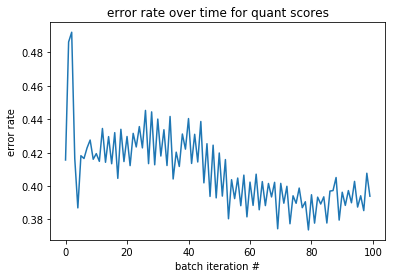

In [34]:
plt.figure(1)
plt.plot(range(0,len(error_rate_list_q)), error_rate_list_q)
plt.title('error rate over time for quant scores')
plt.xlabel('batch iteration #')
plt.ylabel('error rate')

To TAs/graders: I spent so much time on this and couldn't even finish... I really really humbly request for more guidance and background in future assignments for dumber students like me :(

In [ ]:
spark.stop()